#Bài 1. Giải thích sự khác nhau giữa các loại transformer (encoder-only, decoder-only, encoder-decoder)

  a. Việc training mô hình giữa các loại có gì khác nhau? (ví dụ: attention mask)

  b. Nêu 1 số bài toán tiêu biểu cho ứng dụng của từng loại.



**1.Encoder-only**

  ***khác biệt cơ bản:***

    - Cấu trúc: chỉ có encoder, ko có decoder
    - chủ yếu để hiểu ngôn ngữ (text understanding)

  ***a. việc training mô hình & attention mask.***
   
    - objective thường dùng: Mask Language Modeling (MLM), che 1 số token rồi dự đoán.
    - Attention Mask: mô hình "nhìn" cả trái và phải (bidirectional), nhưng bị mask ẩn để học.
    - vd: BERT
  
  ***b.Bài toán ứng dụng tiêu biểu***

    - Phân loại văn bản ( Sentiment analysis, Topic Classification).
    - Nhận dạng thực thể (NER)
    - Tìm độ tương đồng câu (Semantic Similarity)

***2.Decode-only***

  ***Khác biệt cơ bản:***

    - Có decoder, không có encoder
    - Chủ yếu để sinh ngôn ngữ (text generation)

  ***a. Việc training mô hình & attention mask***

    - objective: Auto-regressive language modeling, mô hình dự đoán token kế tiếp dựa trên các token trước.  
    - Attention Mask: Causual (chỉ được nhìn về quá khứ)
    - vd: GPT-2, GPT-3

  ***b. Bài toán ứng dụng tiêu biểu***

    - Sinh văn bản (viết tiếp câu, mô phỏng hội thoại)
    - chatbot, trợ lý ảo ( dựa trên mô hình GPT)
    - Mô hình hóa ngôn ngữ ( Language Modeling)

***3.Encoder-Decoder***

  ***Khác biệt cơ bản***

    - có cả encoder và decoder
    - chuyển đổi chuỗi -> chuỗi ( dịch, tóm tắt..)
  
  ***a. Việc training mô hình & attention mask.***

    - Objective: kết hợp hiểu (encoder) và sinh (decoder). Thường dùng Techer Forcing ( ở decoder) hoặc Denoising (BART)
    - Attention:
      - encoder: bidirectional( tự do nhìn toàn bộ input)
      - decoder: causal (tự sinh) + cross-attention (lấy thông tin từ encoder)
    - vd: T5, BART
  
  ***b. Bài toán và ứng dụng tiêu biểu***
     
     - Dịch máy (Machine Translation)
     - Tóm tắt văn bản (Summarization)
     - Chuyển đổi chuỗi (Chuyển mã code, Q&A, seq2seq)

#Bài 2

##import libraries

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Datasets library of hungging face
from datasets import load_dataset

#check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##dataset

In [3]:
dataset = load_dataset("imdb")
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
# split "train" -> dataframe
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print("train:", train_df.shape)
print("val:", val_df.shape)
print("test:", test_df.shape)

train: (22500, 2)
val: (2500, 2)
test: (25000, 2)


## custom dataset and tokenization

In [5]:
class SentimentDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return{
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
    }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## create dataloader

In [6]:
train_dataset = SentimentDataset(train_df['text'], train_df['label'], tokenizer, max_length=128)
val_dataset = SentimentDataset(val_df['text'], val_df['label'], tokenizer, max_length=128)
test_dataset = SentimentDataset(test_df['text'], test_df['label'], tokenizer, max_length=128)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## create model BERT for classification

In [7]:
# data set có 2 nhãn (0 và 1)
num_classes = 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## optimizer, scheduler and loss func

In [18]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## define train and evaluation

In [19]:
# def train
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model.train()
  losses = []
  correct = 0

  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    logits = outputs.logits

    _, preds = torch.max(logits, dim=1)
    correct += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct.double() / len(data_loader.dataset), np.mean(losses)

In [20]:
#def eval
def eval_model(model, data_loader, loss_fn, device):
  model.eval()
  losses = []
  correct = 0

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      logits = outputs.logits

      _, preds = torch.max(logits, dim=1)
      correct += torch.sum(preds == labels)
      losses.append(loss.cpu().item())

  return correct.double() / len(data_loader.dataset), np.mean(losses)

## training model

In [21]:
history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
  print(f"Train loss {train_loss} accuracy {train_acc}")

  val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
  print(f"Val loss {val_loss} accuracy {val_acc}")

  history["train_acc"].append(train_acc)
  history["train_loss"].append(train_loss)
  history["val_acc"].append(val_acc)
  history["val_loss"].append(val_loss)

Epoch 1/3
Train loss 0.1280257250193914 accuracy 0.953288888888889
Val loss 0.3816220807371317 accuracy 0.8848
Epoch 2/3
Train loss 0.029071829351373136 accuracy 0.9916444444444444
Val loss 0.492916452737709 accuracy 0.8848
Epoch 3/3
Train loss 0.012501599831578097 accuracy 0.9970666666666668
Val loss 0.5571124163018035 accuracy 0.8876000000000001


## visualize

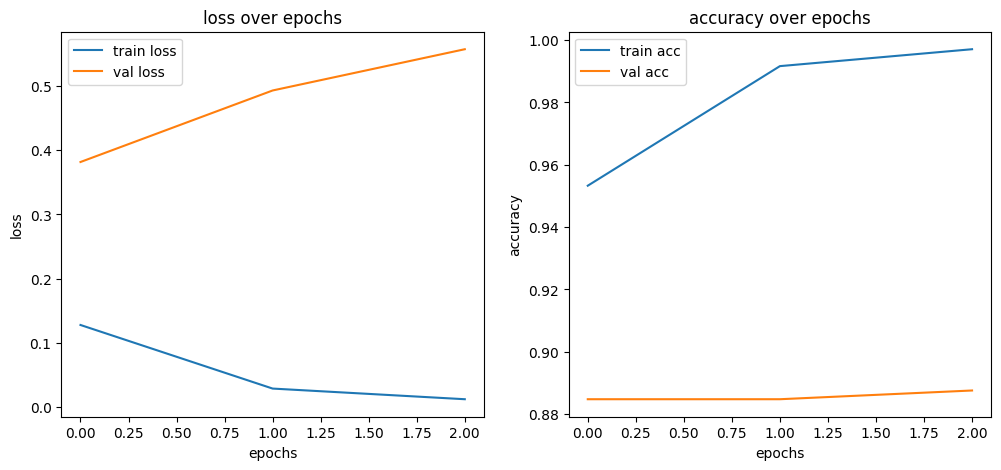

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
# Convert accuracy tensors to NumPy arrays on the CPU before plotting
plt.plot([t.cpu().item() for t in history['train_acc']], label='train acc')
plt.plot([t.cpu().item() for t in history['val_acc']], label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy over epochs')
plt.legend()

plt.show()

In [26]:
#test by GPT
# Cell: Test mô hình với dữ liệu mới

# Chuyển mô hình sang chế độ evaluation
model.eval()

# Ví dụ về một vài câu mới để test
test_texts = [
    "I absolutely loved this movie. It was brilliant!",  # Dự kiến là positive
    "I didn't like the film at all. It was boring and too long."  # Dự kiến là negative
]

# Tokenize các câu này
encoded_inputs = tokenizer(
    test_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Chuyển các tensor sang device (GPU hoặc CPU)
encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}

# Dự đoán với mô hình (không cần tính gradient)
with torch.no_grad():
    outputs = model(**encoded_inputs)

# Lấy logits và chuyển đổi thành nhãn dự đoán
logits = outputs.logits
predictions = torch.argmax(logits, dim=1)

# In kết quả dự đoán
print("Predicted labels:", predictions.cpu().numpy())


Predicted labels: [1 0]
